In [15]:
# Necessary Library Calls
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
from sklearn.model_selection import train_test_split as ttt
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from pylab import *
import gc
import torchmetrics 
import radiomics
from torchvision.utils import save_image
import matplotlib.image
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor


In [16]:
# Global variable definition
IMAGE_PATH = 'data/MICCAI_BraTS_2019_Data_Training'
CSV_FILE='data/MICCAI_BraTS_2019_Data_Training/new.csv'
MODEL_PATH = 'log/22/'

# number of slices, meaning how many slices we are taking from one image file  
SLICE_NUM = 10
# Original Image Size
IMAGE_SIZE=240
# Image size after cropping
HEIGHT=128
WIDTH=144

# Batch size constant
BATCH_SIZE= 1
# input_channel corresponds to the number of different types of images used: 
# e.g: T1, T2, T1_flair, etc. 
# only using one type of images at the moment
INPUT_CHANNEL=2
EPOCH = 50
LEARNING_RATE = 0.001
SLICE_STARTS=torch.load('data/slice_starts.pt')
WEIGHT = torch.load('data/weight.pt')
device = torch.device('cuda')
LOAD_CURRENT = True
LOAD_BEST = False


In [17]:
"""

Data loader for easy data access. 

Output shape for get_item: X [slices, input_channels, W, H ]
                           y [slices, W, H, ]
Notes: the output channel for y has dimension of 1 and has value in range of (0,3).


"""


# Simple helper function for retriving images given the path
def get_image(image_path,image_cat,image_id,image_type):
    t1_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_t1.nii.gz').get_fdata()
    t1ce_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_t1ce.nii.gz').get_fdata()
    t2_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_t2.nii.gz').get_fdata()
    seg_data=nib.load(image_path+'/'+image_cat+'/'+image_id+'/'+image_id+'_seg.nii.gz').get_fdata()
    flair_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_flair.nii.gz').get_fdata()
    result={'t1':t1_data,'t1ce':t1ce_data,'t2':t2_data,'seg':seg_data,'flair':flair_data}
   
    return result[image_type]; 


class BraTS19Dataset(Dataset):
    def __init__(self, csv_f,i_path,i_type):
        self.source=pd.read_csv(csv_f)
        self.image_path=i_path
        self.type=i_type
        self.batch=BATCH_SIZE
    def __len__(self):
        return len(self.source)
     
    def __getitem__(self,idx):
        image_cat=self.source.iloc[idx,0]
        image_id=self.source.iloc[idx,1]
        starts=SLICE_STARTS[idx].int()
        age=self.source.iloc[idx,2]
        sur=self.source.iloc[idx,3]
        stu=self.source.iloc[idx,4]
        if sur<300: 
            cla = 0
        elif sur<450:
            cla=1
        else:
            cla =2
        #classification class 
        
        # get the image and its corresponding mask 
        img = np.zeros((INPUT_CHANNEL,IMAGE_SIZE,IMAGE_SIZE,155))
        
        for i in range(INPUT_CHANNEL):
            img[i]=get_image(self.image_path,image_cat,image_id,self.type[i])
        
     
        mask=get_image(self.image_path,image_cat,image_id,'seg')
        
        
        # change label 4 to 3 for easy index handling
        
        mask[mask==4]=3
        
        # initialize results arrays
        X=np.zeros((INPUT_CHANNEL,HEIGHT,WIDTH,SLICE_NUM))
        y=np.zeros((HEIGHT,WIDTH,SLICE_NUM))
        X = img[:,50:50+HEIGHT,55:55+WIDTH,starts-5:starts-5+SLICE_NUM]
        y = mask[50:50+HEIGHT,55:55+WIDTH,starts-5:starts-5+SLICE_NUM]
        X=torch.from_numpy(X)
        y=torch.from_numpy(y)
        
        
      
       
       
        y = y.long()
#        y = F.one_hot(y,num_classes=4)
        return (X.permute(3,0,1,2),y.permute(2,0,1),(age,sur,stu,cla))
    
def GetBraTS19Dataset(csv,ipath,itype,batch_size=1,shuffle=True,pin_memory=True):
    data = BraTS19Dataset(csv,ipath,itype)
    leng = [int(0.6* len(data)),int(0.2* len(data)),len(data) - int(0.6 * len(data))-int(0.2 * len(data))]
    train,eva,test=torch.utils.data.random_split(data,leng)
    train=DataLoader(train,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    eva=DataLoader(eva,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    test=DataLoader(eva,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    return train,eva,test

In [18]:
# Unet model
class Unet(nn.Module):

    def encoder_block(self,in_channels,out_channels,k=3,conv2d_pad1=(1,1),conv2d_pad2=(1,1)):
        block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=k,padding=conv2d_pad1),
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.Conv2d(out_channels,out_channels,kernel_size=k,padding=conv2d_pad2),
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
        )
        return block
    
    # actual output channel size = output_channel/2
    def decoder_block(self,in_channels,out_channels,k=3,s=2,conv2d_pad1=(1,1),conv2d_pad2=(1,1),convtrans2d_pad=(0,0)):
        block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=k,padding=conv2d_pad1),
            nn.GroupNorm(32,out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=k,padding=conv2d_pad2),
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.ConvTranspose2d(out_channels,int(out_channels/2),kernel_size=2,stride=s,padding=convtrans2d_pad),
        )
        return block
    
    def bottle_neck(self,in_channels,out_channels,k=3):
        block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=k,stride=1,padding=1),
            nn.GroupNorm(32,out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=k,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.GroupNorm(32,out_channels),
            nn.ConvTranspose2d(out_channels,in_channels,kernel_size=2,stride=2,padding=(0,0),output_padding=(0,0)),
        )
        return block
    
        
    def final_block(self,in_channels,out_channels,k):
        block = nn.Sequential(
            nn.Conv2d(in_channels,int(in_channels/2),kernel_size=k,padding=(1,1)),
            nn.GroupNorm(16,int(in_channels/2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(in_channels/2),out_channels,kernel_size=k,padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.GroupNorm(4,out_channels),
            nn.Conv2d(out_channels,out_channels,kernel_size=1,stride=1),
            nn.Softmax(dim=1),
            
        )
        return block
    
    def __init__(self, in_channel, out_channel):
        super(Unet, self).__init__()
        self.en1=self.encoder_block(in_channel,32)
        self.max1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.en2=self.encoder_block(32,64)
        self.max2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.en3=self.encoder_block(64,128)
        self.max3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.en4=self.encoder_block(128,256)
        self.max4 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.bn=self.bottle_neck(256,512)
        self.dc4=self.decoder_block(512,256)
        self.dc3=self.decoder_block(256,128)
        self.dc2=self.decoder_block(128,64)
        self.final=self.final_block(64,out_channel,k=3)
   
    def forward(self,x):
        encoder_block1=self.en1(x)
        mp1 = self.max1(encoder_block1)
        encoder_block2=self.en2(mp1)
        mp2 = self.max2(encoder_block2)
        encoder_block3=self.en3(mp2)
        mp3 = self.max3(encoder_block3)
        encoder_block4=self.en4(mp3)
        mp4 = self.max4(encoder_block4)
        bottleneck_block1 =self.bn(mp4)
        
        cat_block4= torch.cat((bottleneck_block1,encoder_block4),1)
        decoder_block4=self.dc4(cat_block4)
        
        cat_block3= torch.cat((decoder_block4,encoder_block3),1)
        decoder_block3=self.dc3(cat_block3)
        
        cat_block2= torch.cat((decoder_block3,encoder_block2),1)
        decoder_block2=self.dc2(cat_block2)
        
        cat_block1= torch.cat((decoder_block2,encoder_block1),1)
        
        result=self.final(cat_block1)
        
        return result

In [19]:
class DiceScore(nn.Module):

    def __init__(self):
        super(DiceScore, self).__init__()
        
    def forward(self, y_pred, y_true):
        dice = torchmetrics.Dice(average = 'micro').to(device)
        macdice = torchmetrics.Dice(num_classes=4,average = 'macro').to(device)
        assert y_pred.size() == y_true.size()
        y_pred1 = F.one_hot(torch.argmax(y_pred,dim=3),num_classes=4)
      
        yp0 = y_pred1[:,:,:,0].contiguous().view(-1)
        yt0 = y_true[:,:,:,0].contiguous().view(-1)
        t0 = dice(yp0,yt0)
        
        yp1 = y_pred1[:,:,:,1].contiguous().view(-1)
        yt1 = y_true[:,:,:,1].contiguous().view(-1)
        t1 = dice(yp1,yt1)
        
        yp2 = y_pred1[:,:,:,2].contiguous().view(-1)
        yt2 = y_true[:,:,:,2].contiguous().view(-1)
        t2 = dice(yp2,yt2)
        
    
        yp3 = y_pred1[:,:,:,3].contiguous().view(-1)
        yt3 = y_true[:,:,:,3].contiguous().view(-1)
        t3 = dice(yp3,yt3)


        return macdice(y_pred1,y_true),t0,t1,t2,t3


"""

""" 
        
        
        
        
        

'\n\n'

In [20]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        total_loss=0.0
        assert y_pred.size() == y_true.size()
        for i in range(4):
            preds =torch.flatten(y_pred[:,:,:,i])
         
            target =torch.flatten(y_true[:,:,:,i])
            intersection = torch.sum((preds * target))

            dsc = (2. * intersection + 1) / (torch.sum(preds) + torch.sum(target) + 1)
            total_loss+=(1-dsc)
        
        
       
        return total_loss/4

In [21]:
# Train function
def training(dataset, model, opt,  dev, batch_size, lr):
    print('Training in session: ')
    iou=torchmetrics.JaccardIndex('multiclass',num_classes=4,validate_args=False).to(device)
    dic = DiceScore().to(device)
    IoU=[]
    md=[]
    d0=[]
    d1=[]
    d2=[]
    d3=[]
    epoch_loss=0.0
    dataset=tqdm(dataset)
    for index, batch in enumerate(dataset):
        
        # reshape the data and load the data to gpu
        x, y,other= batch 
        a,b,c,d,e=x.shape
        x=x.reshape(a*b,c,d,e)
        x=x.float()

        a,b,c,d=y.shape
        y=y.reshape(a*b,c,d)
        
        x,y=x.to(device),y.to(device)
       
        
      
        
        
        
        loss_fn = DiceLoss().to(device)
       
        # training model
        res = model(x)
        res=res.to(device)
        loss = loss_fn(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device)).to(device)
        
        opt.zero_grad()
        
        loss.backward()
        
        opt.step()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), gc)
        
        
        
        # Loss 
        print("Batch_id: ", index,"Training loss: ", loss.item())
        epoch_loss+=loss.item()
        
        
        
        
        #IoU
        bac = iou(torch.argmax(res,dim = 1).to(device),y.to(device)).to(device)
        print("Batch_id: ", index,"Training IoU: ", bac)
        IoU.append(bac)
        
        
        
        # Dice Score
        
        t,t0,t1,t2,t3=dic(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device))
        
        
            
        print("Batch_id: ", index,"Training Mean Dice Score: ", t)
        md.append(t)
            
        print("Batch_id: ", index,"Training Non-tumor Dice Score: ", t0)
        d0.append(t0)
            
        print("Batch_id: ", index,"Training NCR/NET Dice Score: ", t1)
        d1.append(t1)
            
        print("Batch_id: ", index,"Training ED Dice Score: ", t2)
        d2.append(t2)
            
        print("Batch_id: ", index,"Training ET Dice Score: ", t3)
        d3.append(t3)

        
            
    IoU=torch.tensor(IoU)
    md = torch.tensor(md)
    d0=torch.tensor(d0)
    d1=torch.tensor(d1)
    d2=torch.tensor(d2)
    d3=torch.tensor(d3)
    return torch.mean(IoU),epoch_loss,torch.mean(md),torch.mean(d0),torch.mean(d1),torch.mean(d2),torch.mean(d3)
        
        
        
        





       
        
        
        
#        IoU.append(iou(res,y.float()).to(torch.device('cpu')))
    
    
   

In [22]:
# Evaluation function
def evaluation(dataset, model):
    print('Evaluation in session: ')
    iou=torchmetrics.JaccardIndex('multiclass',num_classes=4,validate_args=False).to(device)
    dic = DiceScore().to(device)
    IoU=[]
    md=[]
    d0=[]
    d1=[]
    d2=[]
    d3=[]
    epoch_loss=0.0
    dataset=tqdm(dataset)
    model.eval()
    with torch.no_grad():
        
        for index, batch in enumerate(dataset):
        
            # reshape the data and load the data to gpu
            x, y,other= batch 
            a,b,c,d,e=x.shape
            x=x.reshape(a*b,c,d,e)
            x=x.float()
        
            a,b,c,d=y.shape
            y=y.reshape(a*b,c,d)
        
            x,y=x.to(device),y.to(device)
       
        
        
        
        
        
            loss_fn = DiceLoss().to(device)
       
            #eval
            res = model(x)
            res=res.to(device)
            loss = loss_fn(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device)).to(device)
        
        
        
            # Loss
            print("Batch_id: ", index,"Eval loss: ", loss.item())
            epoch_loss+=loss.item()
            
            
            # IoU

            bac = iou(torch.argmax(res,dim = 1).to(device),y.to(device)).to(device)
            print("Batch_id: ", index,"Eval IoU: ", bac)
            IoU.append(bac)
            
            # Dice Score
            t,t0,t1,t2,t3=dic(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device))
            
            print("Batch_id: ", index,"Eval Mean Dice Score: ", t)
            md.append(t)
            
            print("Batch_id: ", index,"Eval Non-tumor Dice Score: ", t0)
            d0.append(t0)
            
            print("Batch_id: ", index,"Eval NCR/NET Dice Score: ", t1)
            d1.append(t1)
            
            print("Batch_id: ", index,"Eval ED Dice Score: ", t2)
            d2.append(t2)
            
            print("Batch_id: ", index,"Eval ET Dice Score: ", t3)
            d3.append(t3)
            if index%10==0:
                
                img1=np.zeros((HEIGHT,WIDTH))
                img1=torch.tensor(img1)
                img1[:,:]=res.argmax(dim=1)[5,:,:]
                img1[img1==3]=4
                img2=np.zeros((HEIGHT,WIDTH))
                img2=torch.tensor(img2)
                img2[:,:]=y[5,:,:]
                img2[img2==3]=4
                figure()
                imshow(img1)
                show()
                figure()
                imshow(img2)
                show()
            
            
            

            
    IoU=torch.tensor(IoU)
    md = torch.tensor(md)
    d0=torch.tensor(d0)
    d1=torch.tensor(d1)
    d2=torch.tensor(d2)
    d3=torch.tensor(d3)
    return torch.mean(IoU),epoch_loss,torch.mean(md),torch.mean(d0),torch.mean(d1),torch.mean(d2),torch.mean(d3)
    
    
    

In [37]:
# Load Best Model
def test(dataset):
    print('test in session: ') 
    checkpoint = torch.load(MODEL_PATH+'#22-BEST')
    model = Unet(in_channel=INPUT_CHANNEL,out_channel=4).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch']
    Avg_dice = checkpoint['Eval Dice Scores']
    non = checkpoint['Eval Non-tumor Dice Scores']
    ncr = checkpoint['Eval NCR/NET Dice Scores']
    ed = checkpoint['Eval ED Dice Scores']
    et = checkpoint['Eval ET Dice Scores']
    
    print('Model loaded!','Epoch = ', epoch, 'Mean eval dice scores is: ',Avg_dice)
    print('Dice Scorese Per class: ')
    print('Non-Tumor: ', non)
    print('NCR/NET: ', ncr)
    print('ED: ', ed)
    print('ET: ',et)
    iou=torchmetrics.JaccardIndex('multiclass',num_classes=4,validate_args=False).to(device)
    dic = DiceScore().to(device)
    IoU=[]
    md=[]
    d0=[]
    d1=[]
    d2=[]
    d3=[]
    epoch_loss=0.0
    dataset=tqdm(dataset)
    model.eval()
    with torch.no_grad():
        
        for index, batch in enumerate(dataset):
        
            # reshape the data and load the data to gpu
            x, y,other= batch 
            a,b,c,d,e=x.shape
            x=x.reshape(a*b,c,d,e)
            x=x.float()
        
            a,b,c,d=y.shape
            y=y.reshape(a*b,c,d)
        
            x,y=x.to(device),y.to(device)
       
        
    

    
        
        
        
        
            loss_fn = DiceLoss().to(device)
       
            #test
            res = model(x)
            res=res.to(device)
            loss = loss_fn(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device)).to(device)
        
        
        
            # Loss
            print("Batch_id: ", index,"Test loss: ", loss.item())
            epoch_loss+=loss.item()
            
            
            # IoU

            bac = iou(torch.argmax(res,dim = 1).to(device),y.to(device)).to(device)
            print("Batch_id: ", index,"Test IoU: ", bac)
            IoU.append(bac)
            
            
            # Dice Score
            t,t0,t1,t2,t3=dic(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device))
            
            print("Batch_id: ", index,"Test Mean Dice Score: ", t)
            md.append(t)
            
            print("Batch_id: ", index,"Test Non-tumor Dice Score: ", t0)
            d0.append(t0)
            
            print("Batch_id: ", index,"Test NCR/NET Dice Score: ", t1)
            d1.append(t1)
            
            print("Batch_id: ", index,"Test ED Dice Score: ", t2)
            d2.append(t2)
            
            print("Batch_id: ", index,"Test ET Dice Score: ", t3)
            d3.append(t3)

            img1=np.zeros((HEIGHT,WIDTH))
            img1=torch.tensor(img1)
            img1[:,:]=res.argmax(dim=1)[0,:,:]
            img1[img1==3]=4
            img2=np.zeros((HEIGHT,WIDTH))
            img2=torch.tensor(img2)
            img2[:,:]=y[0,:,:]
            img2[img2==3]=4
            figure()
            imshow(img1)
            show()
            figure()
            imshow(img2)
            show()
            
    IoU=torch.tensor(IoU)
    md = torch.tensor(md)
    d0=torch.tensor(d0)
    d1=torch.tensor(d1)
    d2=torch.tensor(d2)
    d3=torch.tensor(d3)
    print('Avg IoU: ',torch.mean(IoU))
    print('Avg Loss: ',epoch_loss/(36))
    print('Avg Dice Scores: ', torch.mean(md))
    print('Non-Tumor Dice Scores: ',torch.mean(d0))
    print('NCR/NET Dice Scores: ',torch.mean(d1))
    print('ED Dice Scores: ',torch.mean(d2))
    print('ET Dice Scores: ', torch.mean(d3))
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [38]:
# main

def main(BEST_EVAL):
    if LOAD_CURRENT:
        train_data = torch.load(MODEL_PATH+'trdata.pth')
        eval_data = torch.load(MODEL_PATH+'edata.pth')
        test_data = torch.load(MODEL_PATH+'tdata.pth')
    else:
        train_data,eval_data,test_data = GetBraTS19Dataset(CSV_FILE,IMAGE_PATH,['t1ce','flair'],batch_size=BATCH_SIZE)
        torch.save(train_data, MODEL_PATH+'trdata.pth')
        torch.save(eval_data, MODEL_PATH+'edata.pth')
        torch.save(test_data,MODEL_PATH+'tdata.pth')
    
    print('Data Loaded!')
    
    
    
    
    
    model = Unet(in_channel=INPUT_CHANNEL,out_channel=4).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    sc = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=5,factor = 0.5,threshold=0.1,mode = 'max',verbose = True)
    if LOAD_CURRENT:
        checkpoint = torch.load(MODEL_PATH+'#22-current')
        model.load_state_dict(checkpoint['model_state_dict'])
        opt.load_state_dict(checkpoint['optim_state_dict'])
        sc.load_state_dict(checkpoint['sche'])
        index =torch.load(MODEL_PATH+'index.pt')
        loss_value=torch.load(MODEL_PATH+'tloss.pt')
        accuracy=torch.load(MODEL_PATH+'tac.pt')
        eval_loss=torch.load(MODEL_PATH+'eloss.pt')
        eval_accuracy=torch.load(MODEL_PATH+'eacc.pt')
        mean_dice=torch.load(MODEL_PATH+'md.pt')
        d0=torch.load(MODEL_PATH+'d0.pt')
        d1=torch.load(MODEL_PATH+'d1.pt')
        d2=torch.load(MODEL_PATH+'d2.pt')
        d3=torch.load(MODEL_PATH+'d3.pt')
        e_mean_dice=torch.load(MODEL_PATH+'emd.pt')
        ed0=torch.load(MODEL_PATH+'ed0.pt')
        ed1=torch.load(MODEL_PATH+'ed1.pt')
        ed2=torch.load(MODEL_PATH+'ed2.pt')
        ed3=torch.load(MODEL_PATH+'ed3.pt')     
        ep = torch.load(MODEL_PATH+'ep.pt')
        
    else:
        index =[]
        loss_value=[]
        accuracy=[]
        eval_loss=[]
        eval_accuracy=[]
        mean_dice=[]
        d0=[]
        d1=[]
        d2=[]
        d3=[]
        e_mean_dice=[]
        ed0=[]
        ed1=[]
        ed2=[]
        ed3=[]
        ep = 0 
    
    
    for i in range (ep,EPOCH):
        print(f'Epoch: {i}')
        
        acc, loss_val,md,di0,di1,di2,di3=training(train_data,model.train(),opt, device,BATCH_SIZE,LEARNING_RATE)
        
        eacc,eloss_val,emd,edi0,edi1,edi2,edi3=evaluation(eval_data,model.eval())
        sc.step(eloss_val)
        
        loss_value.append(loss_val/len(train_data.sampler))
        accuracy.append(acc)
        mean_dice.append(md)
        d0.append(di0)
        d1.append(di1)
        d2.append(di2)
        d3.append(di3)
        
        eval_loss.append(eloss_val/len(eval_data.sampler))
        eval_accuracy.append(eacc)
        e_mean_dice.append(emd)
        ed0.append(edi0)
        ed1.append(edi1)
        ed2.append(edi2)
        ed3.append(edi3)
        
        index.append(i)
        ep=ep+1
        
        torch.save(index,MODEL_PATH+'index.pt')
        torch.save(loss_value,MODEL_PATH+'tloss.pt')
        torch.save(accuracy,MODEL_PATH+'tac.pt')
        torch.save(eval_loss,MODEL_PATH+'eloss.pt')
        torch.save(eval_accuracy,MODEL_PATH+'eacc.pt')
        torch.save(mean_dice,MODEL_PATH+'md.pt')
        torch.save(d0,MODEL_PATH+'d0.pt')
        torch.save(d1,MODEL_PATH+'d1.pt')
        torch.save(d2,MODEL_PATH+'d2.pt')
        torch.save(d3,MODEL_PATH+'d3.pt')
        torch.save(e_mean_dice,MODEL_PATH+'emd.pt')
        torch.save(ed0,MODEL_PATH+'ed0.pt')
        torch.save(ed1,MODEL_PATH+'ed1.pt')
        torch.save(ed2,MODEL_PATH+'ed2.pt')
        torch.save(ed3,MODEL_PATH+'ed3.pt')     
        torch.save(ep,MODEL_PATH+'ep.pt')
        
        
        print('Epoch ',i,'Training loss: ',loss_val/len(train_data.sampler))
        print('Epoch ',i,'Evaluation loss: ',eloss_val/len(eval_data.sampler))
        
        print('Epoch ',i,'Training accuracy : ',acc)
        print('Epoch ',i,'Evaluation accuracy : ',eacc)
        
        print('Epoch ',i,'Training Mean Dice Score: ',md)
        print('Epoch ',i,'Eval Mean Dice Score: ',emd)
        
        print('Epoch ',i,'Training Non-tumor Dice Score: ',di0)
        print('Epoch ',i,'Eval Non-tumor Dice Score: ',edi0)
       
        print('Epoch ',i,'Training NCR/NET Dice Score: ',di1)
        print('Epoch ',i,'Eval NCR/NET Dice Score: ',edi1)
        
        print('Epoch ',i,'Training ED Dice Score: ',di2)
        print('Epoch ',i,'Eval ED Dice Score: ',edi2)
        
        print('Epoch ',i,'Training ET Dice Score: ',di3)
        print('Epoch ',i,'Eval ET Dice Score: ',edi3)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optim_state_dict': opt.state_dict(),
            'epoch': i,
            'sche':sc.state_dict(),
            'Training loss_values': loss_val/len(train_data.sampler),
            'Training accuracy':acc,
            'Eval loss_values': eloss_val/len(eval_data.sampler),
            'Eval IoU':eacc,
            'Training Dice Scores':md,
            'Eval Dice Scores': emd,
            'Training Non-tumor Dice Scores':di0,
            'Eval Non-tumor Dice Scores':edi0,   
            'Training NCR/NET Dice Scores': di1,
            'Eval NCR/NET Dice Scores': edi1,   
            'Training ED Dice Scores': di2,
            'Eval ED Dice Scores': edi2,    
            'Training ET Dice Scores': di3,
            'Eval ET Dice Scores': edi3,    
            }, MODEL_PATH+'#22-current')
        print('Epoch completed and model successfully saved')
        if BEST_EVAL < eacc :
            torch.save({
            'model_state_dict': model.state_dict(),
            'optim_state_dict': opt.state_dict(),
            'epoch': i,
            'sche':sc.state_dict(),
            'Training loss_values': loss_val/len(train_data.sampler),
            'Training accuracy':acc,
            'Eval loss_values': eloss_val/len(eval_data.sampler),
            'Eval IoU':eacc,
            'Training Dice Scores':md,
            'Eval Dice Scores': emd,
            'Training Non-tumor Dice Scores':di0,
            'Eval Non-tumor Dice Scores':edi0,   
            'Training NCR/NET Dice Scores': di1,
            'Eval NCR/NET Dice Scores': edi1,   
            'Training ED Dice Scores': di2,
            'Eval ED Dice Scores': edi2,    
            'Training ET Dice Scores': di3,
            'Eval ET Dice Scores': edi3,    
            }, MODEL_PATH+'#22-BEST')
            print("Best Model saved!")
            BEST_EVAL = eacc
        gc.collect()
        torch.cuda.empty_cache()
        if eacc > 0.80:
            break
        
    plt.plot(index, loss_value, label ="Training ")
    plt.plot(index,eval_loss, label = "Validation")
    plt.title("Training and Validation Loss Curve: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Average Loss ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and eval Loss plot.png')
    plt.show()
    
    
    plt.plot(index, accuracy,label ="Training ")
    plt.plot(index, eval_accuracy,label ="Validation ")
    plt.title("Training and Validation IoU Scores (batch_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM, LEARNING_RATE))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (Mean IoU Scores)")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and eval Accuracy plot.png')
    plt.show()
    
    plt.plot(index, mean_dice, label ="Training ")
    plt.plot(index,e_mean_dice, label = "Validation")
    plt.title("Training and Validation Mean Dice Scores: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Mean Dice Scores: ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and eval avg dice plot.png')
    plt.show()
    
    plt.plot(index, d0, label ="Non-Tumor ")
    plt.plot(index,d1, label = "NCT/NET")
    plt.plot(index, d2, label ="ED ")
    plt.plot(index,d3, label = "ET")
    plt.title("Training Dice Scores per class: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Mean Dice Scores: ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training dice per class plot.png')
    plt.show()
    
    plt.plot(index, ed0, label ="Non-Tumor ")
    plt.plot(index,ed1, label = "NCT/NET")
    plt.plot(index, ed2, label ="ED ")
    plt.plot(index,ed3, label = "ET")
    plt.title("Validation Dice Scores per class: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Mean Dice Scores: ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Eval dice per class plot.png')
    plt.show()
    test(test_data.dataset)

In [39]:
gc.collect()
torch.cuda.empty_cache()

Data Loaded!


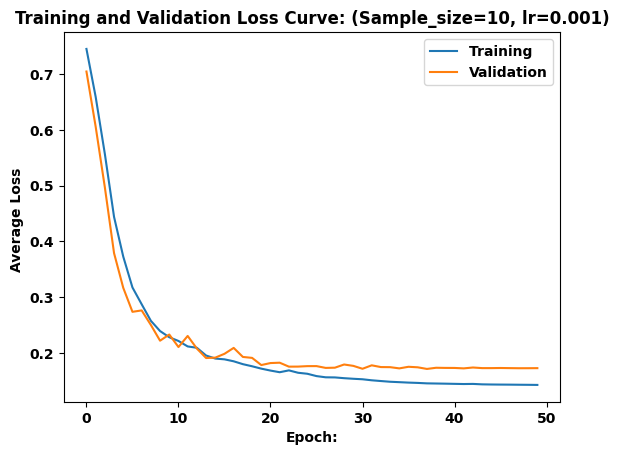

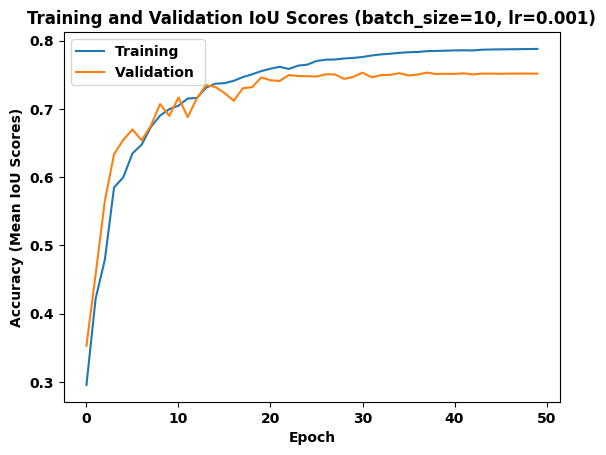

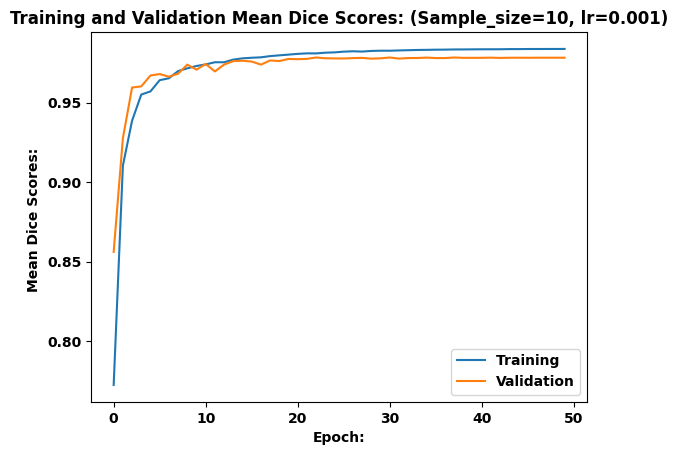

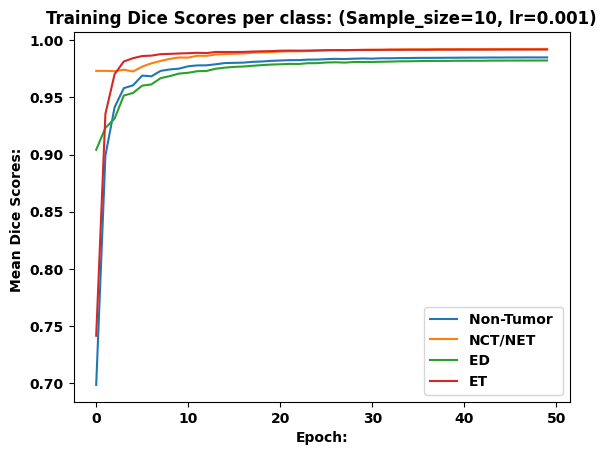

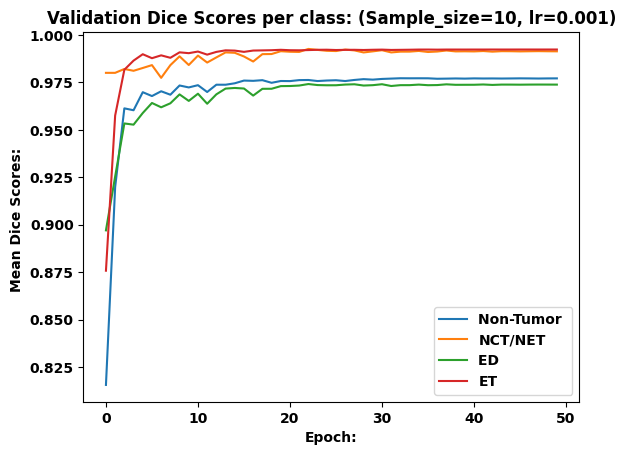

test in session: 
Model loaded! Epoch =  37 Mean eval dice scores is:  tensor(0.9784)
Dice Scorese Per class: 
Non-Tumor:  tensor(0.9770)
NCR/NET:  tensor(0.9918)
ED:  tensor(0.9740)
ET:  tensor(0.9923)


  0%|          | 0/36 [00:00<?, ?it/s]

Batch_id:  0 Test loss:  0.4465419054031372
Batch_id:  0 Test IoU:  tensor(0.4741, device='cuda:0')
Batch_id:  0 Test Mean Dice Score:  tensor(0.9727, device='cuda:0')
Batch_id:  0 Test Non-tumor Dice Score:  tensor(0.9601, device='cuda:0')
Batch_id:  0 Test NCR/NET Dice Score:  tensor(0.9919, device='cuda:0')
Batch_id:  0 Test ED Dice Score:  tensor(0.9694, device='cuda:0')
Batch_id:  0 Test ET Dice Score:  tensor(0.9968, device='cuda:0')


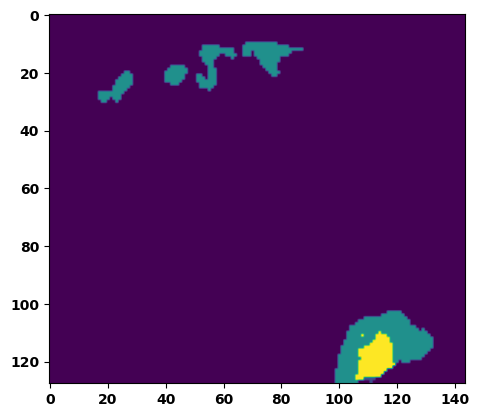

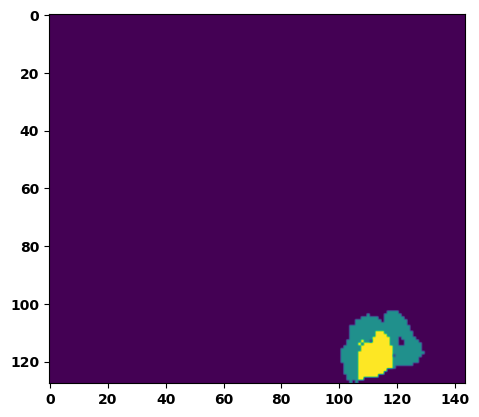

  3%|▎         | 1/36 [00:01<00:38,  1.10s/it]

Batch_id:  1 Test loss:  0.10728339850902557
Batch_id:  1 Test IoU:  tensor(0.8149, device='cuda:0')
Batch_id:  1 Test Mean Dice Score:  tensor(0.9859, device='cuda:0')
Batch_id:  1 Test Non-tumor Dice Score:  tensor(0.9880, device='cuda:0')
Batch_id:  1 Test NCR/NET Dice Score:  tensor(0.9917, device='cuda:0')
Batch_id:  1 Test ED Dice Score:  tensor(0.9876, device='cuda:0')
Batch_id:  1 Test ET Dice Score:  tensor(0.9904, device='cuda:0')


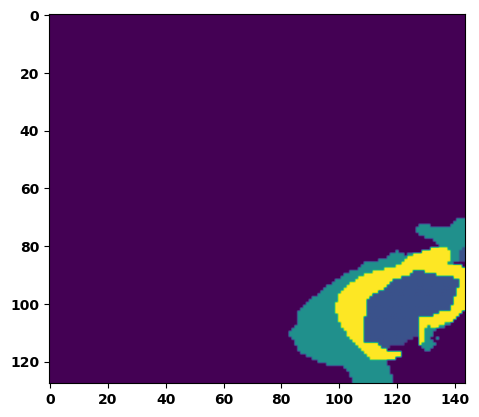

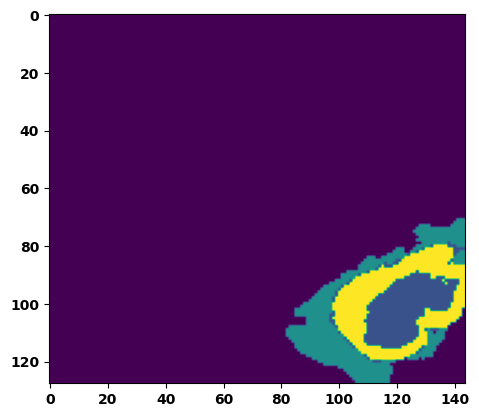

  6%|▌         | 2/36 [00:02<00:38,  1.13s/it]

Batch_id:  2 Test loss:  0.06773948669433594
Batch_id:  2 Test IoU:  tensor(0.8830, device='cuda:0')
Batch_id:  2 Test Mean Dice Score:  tensor(0.9858, device='cuda:0')
Batch_id:  2 Test Non-tumor Dice Score:  tensor(0.9811, device='cuda:0')
Batch_id:  2 Test NCR/NET Dice Score:  tensor(0.9980, device='cuda:0')
Batch_id:  2 Test ED Dice Score:  tensor(0.9819, device='cuda:0')
Batch_id:  2 Test ET Dice Score:  tensor(0.9964, device='cuda:0')


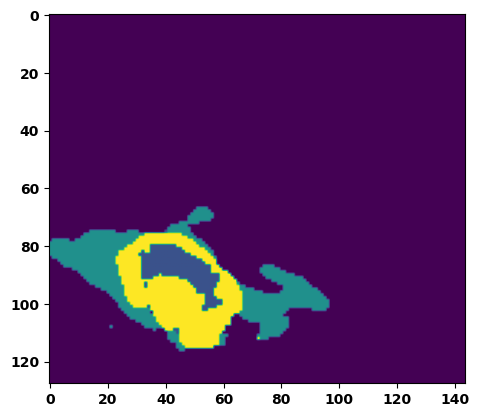

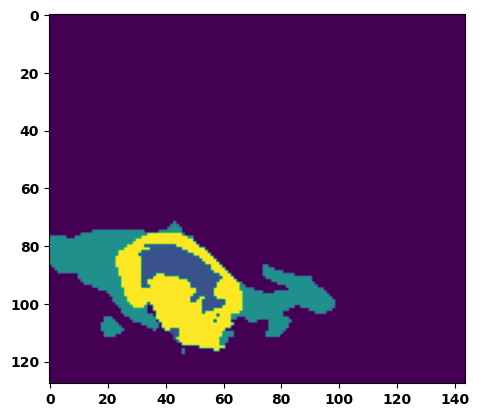

  8%|▊         | 3/36 [00:03<00:38,  1.16s/it]

Batch_id:  3 Test loss:  0.06342144310474396
Batch_id:  3 Test IoU:  tensor(0.8932, device='cuda:0')
Batch_id:  3 Test Mean Dice Score:  tensor(0.9907, device='cuda:0')
Batch_id:  3 Test Non-tumor Dice Score:  tensor(0.9905, device='cuda:0')
Batch_id:  3 Test NCR/NET Dice Score:  tensor(0.9979, device='cuda:0')
Batch_id:  3 Test ED Dice Score:  tensor(0.9890, device='cuda:0')
Batch_id:  3 Test ET Dice Score:  tensor(0.9948, device='cuda:0')


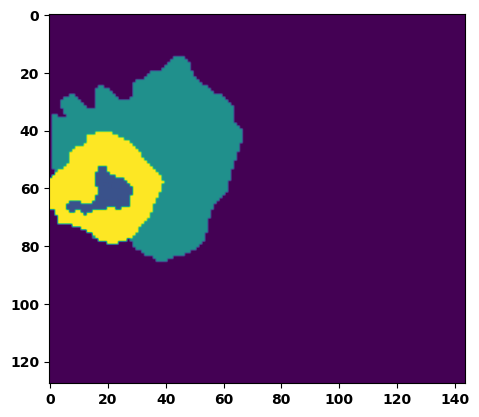

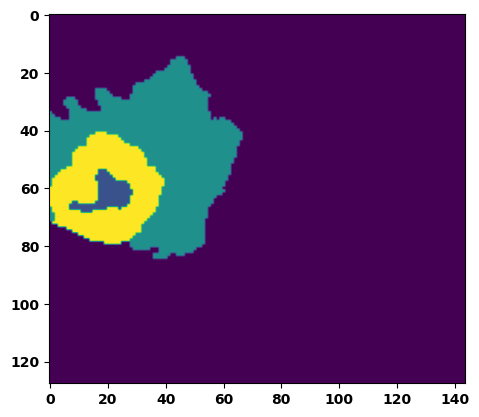

 11%|█         | 4/36 [00:04<00:39,  1.24s/it]

Batch_id:  4 Test loss:  0.13005533814430237
Batch_id:  4 Test IoU:  tensor(0.7977, device='cuda:0')
Batch_id:  4 Test Mean Dice Score:  tensor(0.9839, device='cuda:0')
Batch_id:  4 Test Non-tumor Dice Score:  tensor(0.9818, device='cuda:0')
Batch_id:  4 Test NCR/NET Dice Score:  tensor(0.9955, device='cuda:0')
Batch_id:  4 Test ED Dice Score:  tensor(0.9769, device='cuda:0')
Batch_id:  4 Test ET Dice Score:  tensor(0.9975, device='cuda:0')


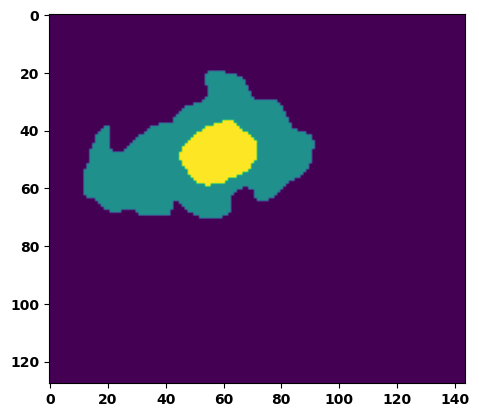

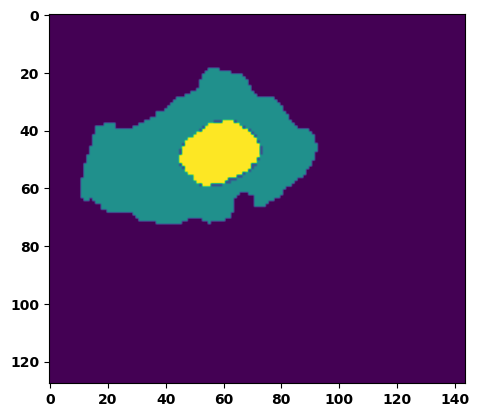

 14%|█▍        | 5/36 [00:05<00:36,  1.17s/it]

Batch_id:  5 Test loss:  0.1911361813545227
Batch_id:  5 Test IoU:  tensor(0.7122, device='cuda:0')
Batch_id:  5 Test Mean Dice Score:  tensor(0.9820, device='cuda:0')
Batch_id:  5 Test Non-tumor Dice Score:  tensor(0.9825, device='cuda:0')
Batch_id:  5 Test NCR/NET Dice Score:  tensor(0.9957, device='cuda:0')
Batch_id:  5 Test ED Dice Score:  tensor(0.9763, device='cuda:0')
Batch_id:  5 Test ET Dice Score:  tensor(0.9915, device='cuda:0')


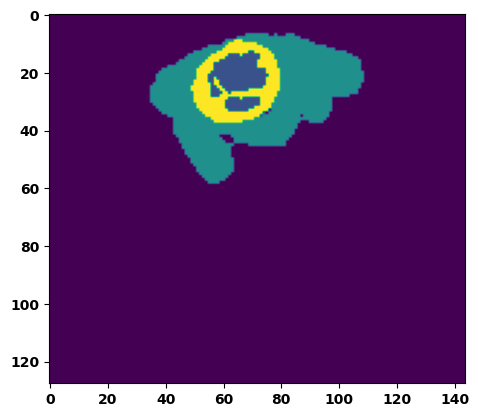

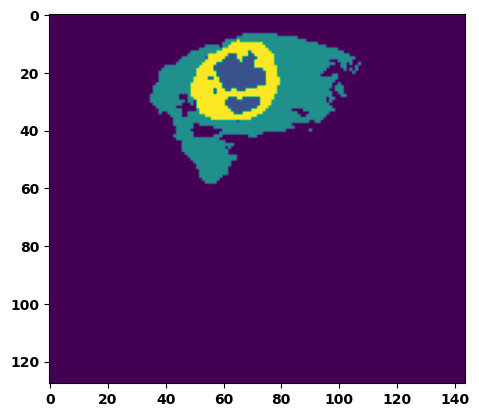

 17%|█▋        | 6/36 [00:06<00:34,  1.15s/it]

Batch_id:  6 Test loss:  0.12498433887958527
Batch_id:  6 Test IoU:  tensor(0.7869, device='cuda:0')
Batch_id:  6 Test Mean Dice Score:  tensor(0.9776, device='cuda:0')
Batch_id:  6 Test Non-tumor Dice Score:  tensor(0.9796, device='cuda:0')
Batch_id:  6 Test NCR/NET Dice Score:  tensor(0.9897, device='cuda:0')
Batch_id:  6 Test ED Dice Score:  tensor(0.9764, device='cuda:0')
Batch_id:  6 Test ET Dice Score:  tensor(0.9872, device='cuda:0')


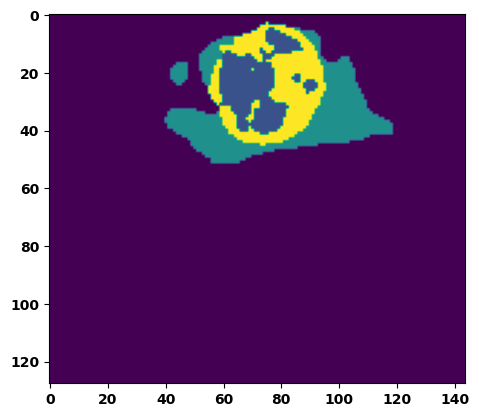

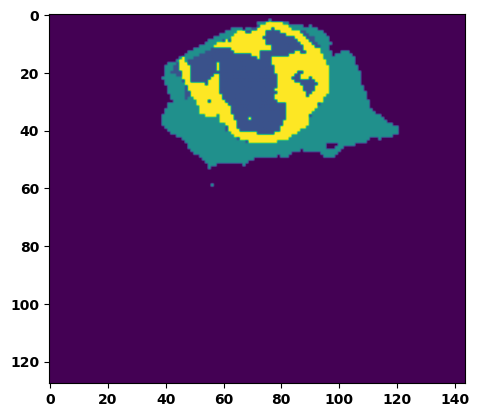

 19%|█▉        | 7/36 [00:08<00:33,  1.16s/it]

Batch_id:  7 Test loss:  0.33130449056625366
Batch_id:  7 Test IoU:  tensor(0.5879, device='cuda:0')
Batch_id:  7 Test Mean Dice Score:  tensor(0.9483, device='cuda:0')
Batch_id:  7 Test Non-tumor Dice Score:  tensor(0.9274, device='cuda:0')
Batch_id:  7 Test NCR/NET Dice Score:  tensor(0.9969, device='cuda:0')
Batch_id:  7 Test ED Dice Score:  tensor(0.9230, device='cuda:0')
Batch_id:  7 Test ET Dice Score:  tensor(0.9975, device='cuda:0')


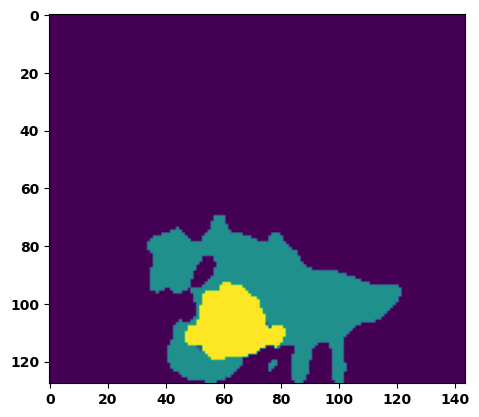

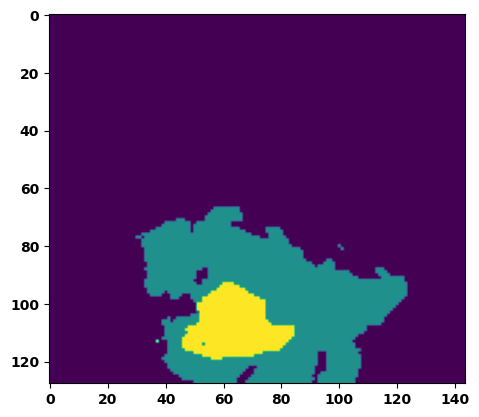

 22%|██▏       | 8/36 [00:09<00:31,  1.13s/it]

Batch_id:  8 Test loss:  0.05250385403633118
Batch_id:  8 Test IoU:  tensor(0.9083, device='cuda:0')
Batch_id:  8 Test Mean Dice Score:  tensor(0.9942, device='cuda:0')
Batch_id:  8 Test Non-tumor Dice Score:  tensor(0.9952, device='cuda:0')
Batch_id:  8 Test NCR/NET Dice Score:  tensor(0.9983, device='cuda:0')
Batch_id:  8 Test ED Dice Score:  tensor(0.9937, device='cuda:0')
Batch_id:  8 Test ET Dice Score:  tensor(0.9954, device='cuda:0')


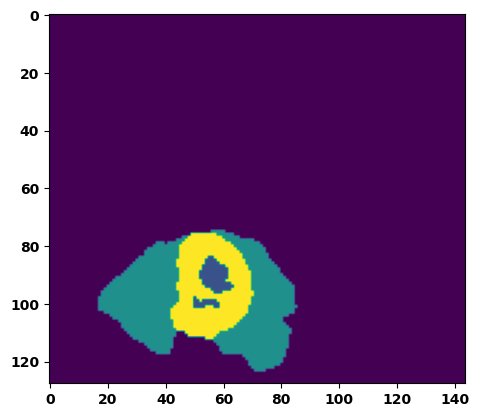

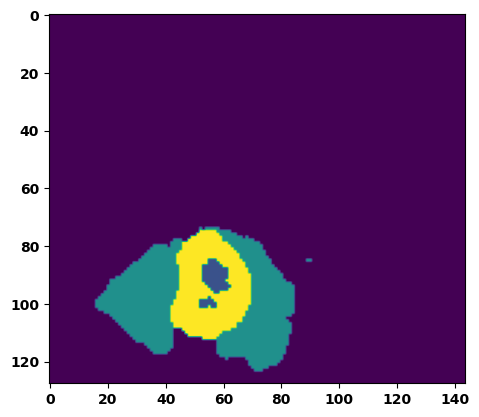

 25%|██▌       | 9/36 [00:10<00:31,  1.18s/it]

Batch_id:  9 Test loss:  0.40148383378982544
Batch_id:  9 Test IoU:  tensor(0.5096, device='cuda:0')
Batch_id:  9 Test Mean Dice Score:  tensor(0.9440, device='cuda:0')
Batch_id:  9 Test Non-tumor Dice Score:  tensor(0.9652, device='cuda:0')
Batch_id:  9 Test NCR/NET Dice Score:  tensor(0.9429, device='cuda:0')
Batch_id:  9 Test ED Dice Score:  tensor(0.9314, device='cuda:0')
Batch_id:  9 Test ET Dice Score:  tensor(0.9923, device='cuda:0')


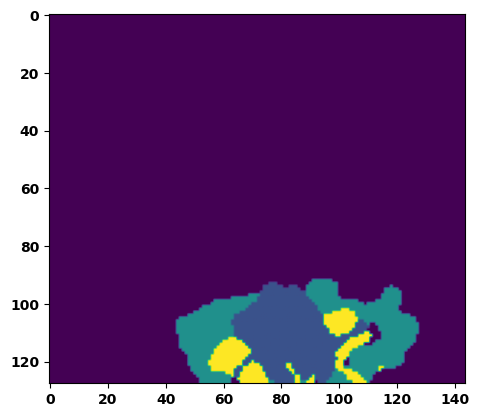

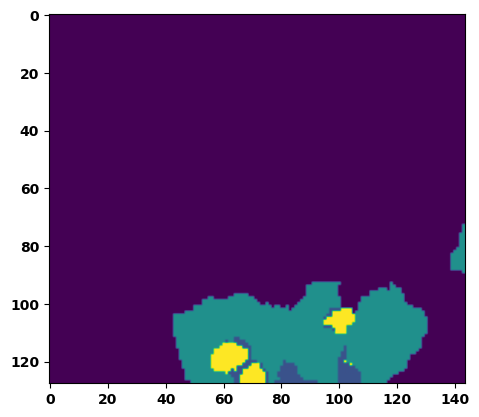

 28%|██▊       | 10/36 [00:11<00:30,  1.16s/it]

Batch_id:  10 Test loss:  0.059885457158088684
Batch_id:  10 Test IoU:  tensor(0.8958, device='cuda:0')
Batch_id:  10 Test Mean Dice Score:  tensor(0.9860, device='cuda:0')
Batch_id:  10 Test Non-tumor Dice Score:  tensor(0.9869, device='cuda:0')
Batch_id:  10 Test NCR/NET Dice Score:  tensor(0.9953, device='cuda:0')
Batch_id:  10 Test ED Dice Score:  tensor(0.9851, device='cuda:0')
Batch_id:  10 Test ET Dice Score:  tensor(0.9907, device='cuda:0')


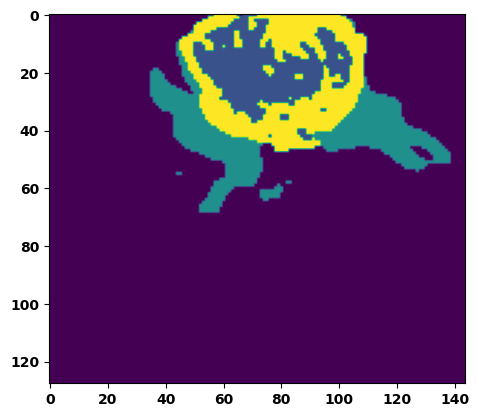

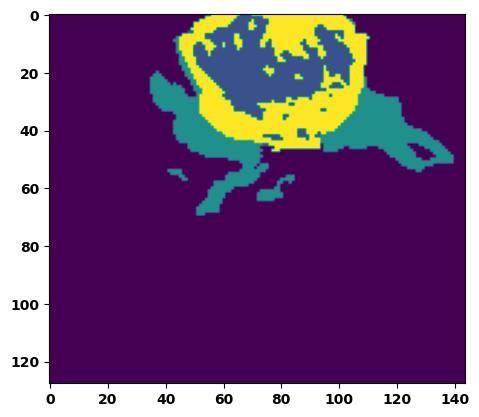

 31%|███       | 11/36 [00:13<00:30,  1.23s/it]

Batch_id:  11 Test loss:  0.145707905292511
Batch_id:  11 Test IoU:  tensor(0.8132, device='cuda:0')
Batch_id:  11 Test Mean Dice Score:  tensor(0.9948, device='cuda:0')
Batch_id:  11 Test Non-tumor Dice Score:  tensor(0.9934, device='cuda:0')
Batch_id:  11 Test NCR/NET Dice Score:  tensor(0.9997, device='cuda:0')
Batch_id:  11 Test ED Dice Score:  tensor(0.9928, device='cuda:0')
Batch_id:  11 Test ET Dice Score:  tensor(0.9985, device='cuda:0')


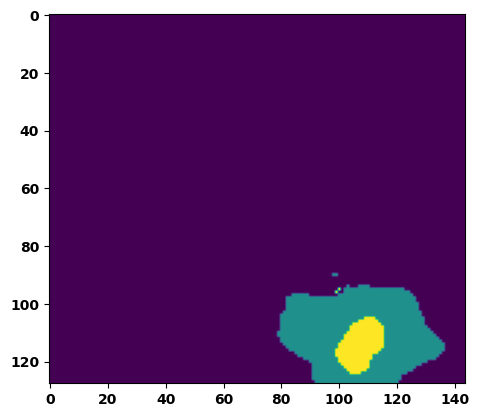

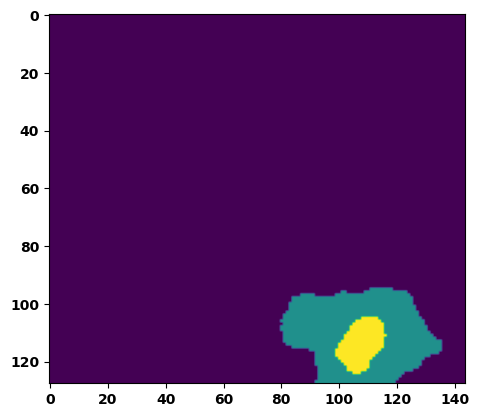

 33%|███▎      | 12/36 [00:14<00:29,  1.21s/it]

Batch_id:  12 Test loss:  0.08936093747615814
Batch_id:  12 Test IoU:  tensor(0.8438, device='cuda:0')
Batch_id:  12 Test Mean Dice Score:  tensor(0.9816, device='cuda:0')
Batch_id:  12 Test Non-tumor Dice Score:  tensor(0.9877, device='cuda:0')
Batch_id:  12 Test NCR/NET Dice Score:  tensor(0.9916, device='cuda:0')
Batch_id:  12 Test ED Dice Score:  tensor(0.9823, device='cuda:0')
Batch_id:  12 Test ET Dice Score:  tensor(0.9834, device='cuda:0')


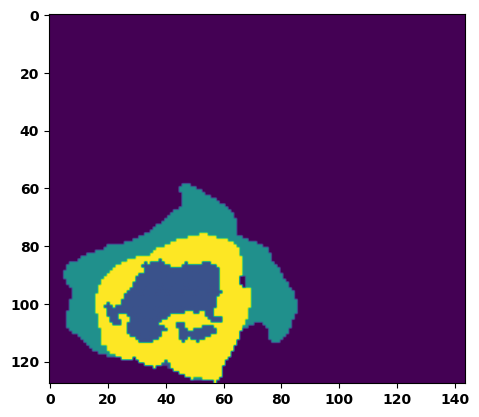

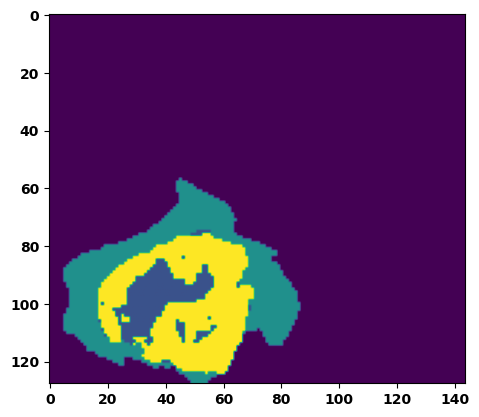

 36%|███▌      | 13/36 [00:15<00:27,  1.21s/it]

Batch_id:  13 Test loss:  0.180290088057518
Batch_id:  13 Test IoU:  tensor(0.7231, device='cuda:0')
Batch_id:  13 Test Mean Dice Score:  tensor(0.9871, device='cuda:0')
Batch_id:  13 Test Non-tumor Dice Score:  tensor(0.9906, device='cuda:0')
Batch_id:  13 Test NCR/NET Dice Score:  tensor(0.9929, device='cuda:0')
Batch_id:  13 Test ED Dice Score:  tensor(0.9827, device='cuda:0')
Batch_id:  13 Test ET Dice Score:  tensor(0.9951, device='cuda:0')


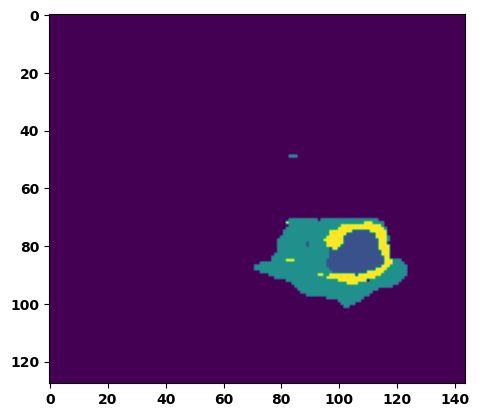

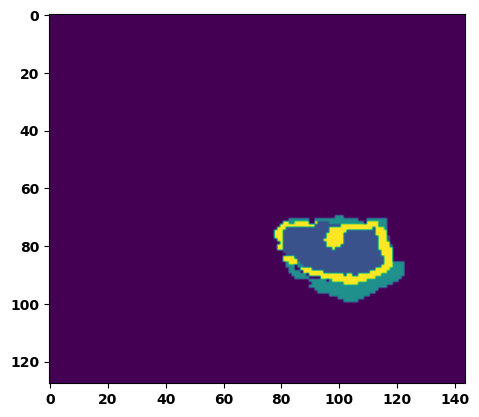

 39%|███▉      | 14/36 [00:16<00:26,  1.21s/it]

Batch_id:  14 Test loss:  0.2803409695625305
Batch_id:  14 Test IoU:  tensor(0.6050, device='cuda:0')
Batch_id:  14 Test Mean Dice Score:  tensor(0.9477, device='cuda:0')
Batch_id:  14 Test Non-tumor Dice Score:  tensor(0.9500, device='cuda:0')
Batch_id:  14 Test NCR/NET Dice Score:  tensor(0.9694, device='cuda:0')
Batch_id:  14 Test ED Dice Score:  tensor(0.9322, device='cuda:0')
Batch_id:  14 Test ET Dice Score:  tensor(0.9916, device='cuda:0')


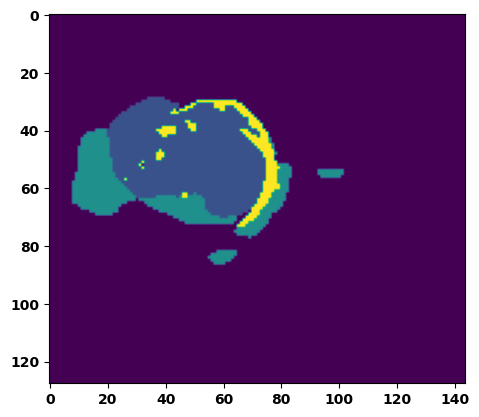

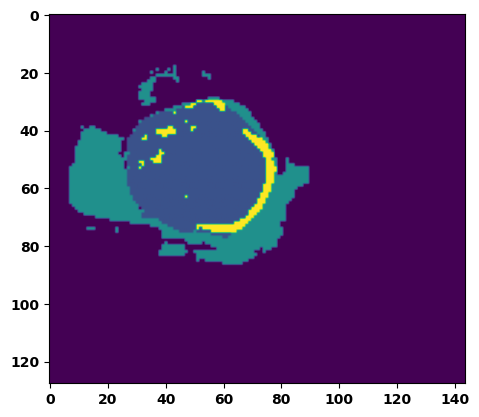

 42%|████▏     | 15/36 [00:17<00:25,  1.20s/it]

Batch_id:  15 Test loss:  0.4106597304344177
Batch_id:  15 Test IoU:  tensor(0.5194, device='cuda:0')
Batch_id:  15 Test Mean Dice Score:  tensor(0.9763, device='cuda:0')
Batch_id:  15 Test Non-tumor Dice Score:  tensor(0.9666, device='cuda:0')
Batch_id:  15 Test NCR/NET Dice Score:  tensor(0.9961, device='cuda:0')
Batch_id:  15 Test ED Dice Score:  tensor(0.9686, device='cuda:0')
Batch_id:  15 Test ET Dice Score:  tensor(0.9977, device='cuda:0')


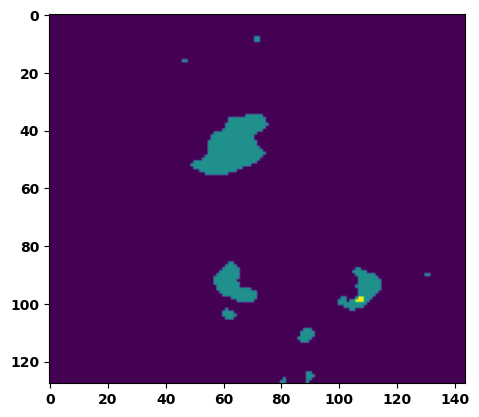

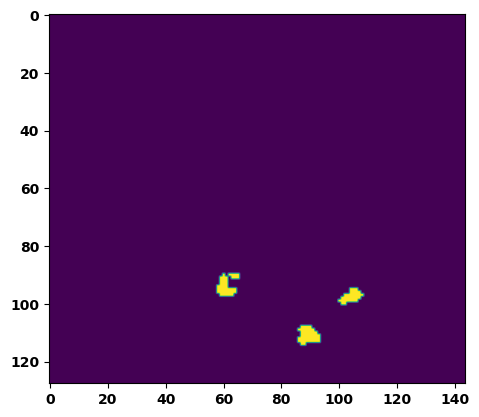

 44%|████▍     | 16/36 [00:19<00:25,  1.26s/it]

Batch_id:  16 Test loss:  0.17750367522239685
Batch_id:  16 Test IoU:  tensor(0.7193, device='cuda:0')
Batch_id:  16 Test Mean Dice Score:  tensor(0.9499, device='cuda:0')
Batch_id:  16 Test Non-tumor Dice Score:  tensor(0.9642, device='cuda:0')
Batch_id:  16 Test NCR/NET Dice Score:  tensor(0.9597, device='cuda:0')
Batch_id:  16 Test ED Dice Score:  tensor(0.9468, device='cuda:0')
Batch_id:  16 Test ET Dice Score:  tensor(0.9790, device='cuda:0')


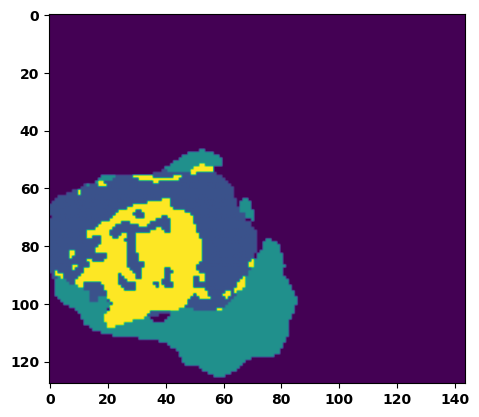

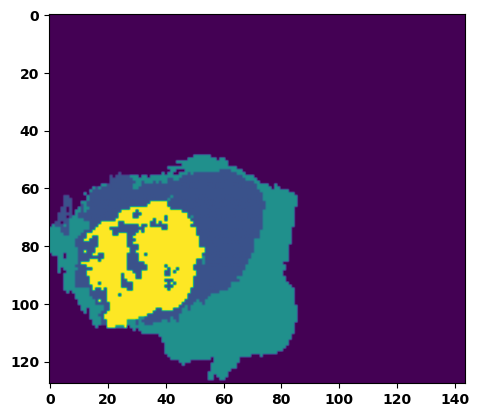

 47%|████▋     | 17/36 [00:20<00:23,  1.25s/it]

Batch_id:  17 Test loss:  0.14520594477653503
Batch_id:  17 Test IoU:  tensor(0.7717, device='cuda:0')
Batch_id:  17 Test Mean Dice Score:  tensor(0.9788, device='cuda:0')
Batch_id:  17 Test Non-tumor Dice Score:  tensor(0.9767, device='cuda:0')
Batch_id:  17 Test NCR/NET Dice Score:  tensor(0.9937, device='cuda:0')
Batch_id:  17 Test ED Dice Score:  tensor(0.9766, device='cuda:0')
Batch_id:  17 Test ET Dice Score:  tensor(0.9893, device='cuda:0')


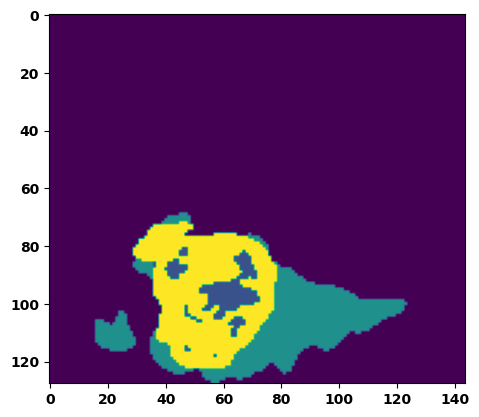

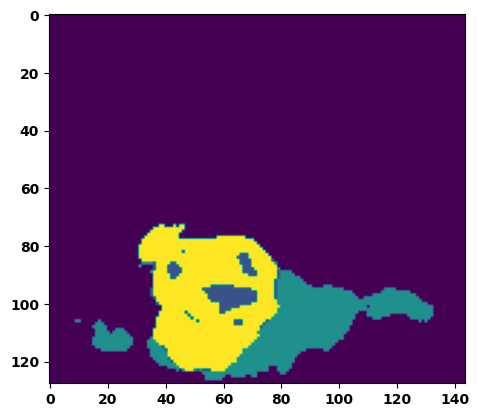

 50%|█████     | 18/36 [00:21<00:21,  1.20s/it]

Batch_id:  18 Test loss:  0.2444055676460266
Batch_id:  18 Test IoU:  tensor(0.6646, device='cuda:0')
Batch_id:  18 Test Mean Dice Score:  tensor(0.9875, device='cuda:0')
Batch_id:  18 Test Non-tumor Dice Score:  tensor(0.9852, device='cuda:0')
Batch_id:  18 Test NCR/NET Dice Score:  tensor(0.9979, device='cuda:0')
Batch_id:  18 Test ED Dice Score:  tensor(0.9841, device='cuda:0')
Batch_id:  18 Test ET Dice Score:  tensor(0.9952, device='cuda:0')


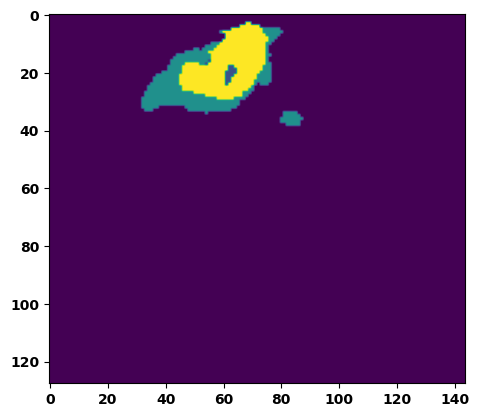

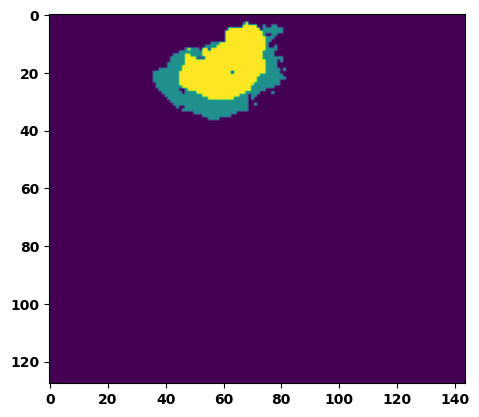

 53%|█████▎    | 19/36 [00:22<00:21,  1.25s/it]

Batch_id:  19 Test loss:  0.15528935194015503
Batch_id:  19 Test IoU:  tensor(0.7602, device='cuda:0')
Batch_id:  19 Test Mean Dice Score:  tensor(0.9793, device='cuda:0')
Batch_id:  19 Test Non-tumor Dice Score:  tensor(0.9778, device='cuda:0')
Batch_id:  19 Test NCR/NET Dice Score:  tensor(0.9877, device='cuda:0')
Batch_id:  19 Test ED Dice Score:  tensor(0.9824, device='cuda:0')
Batch_id:  19 Test ET Dice Score:  tensor(0.9899, device='cuda:0')


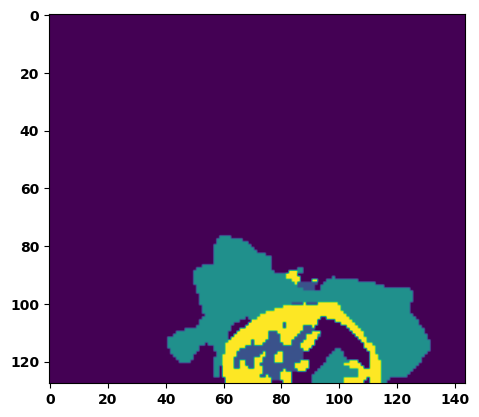

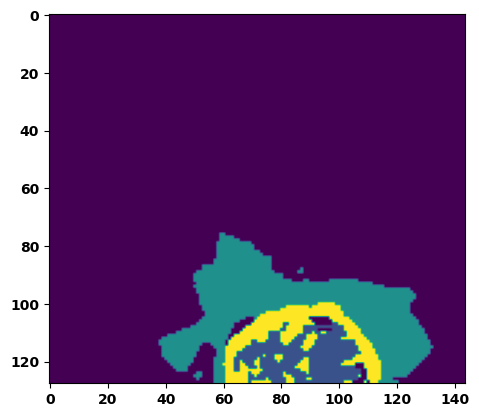

 56%|█████▌    | 20/36 [00:24<00:19,  1.25s/it]

Batch_id:  20 Test loss:  0.17476806044578552
Batch_id:  20 Test IoU:  tensor(0.7267, device='cuda:0')
Batch_id:  20 Test Mean Dice Score:  tensor(0.9845, device='cuda:0')
Batch_id:  20 Test Non-tumor Dice Score:  tensor(0.9871, device='cuda:0')
Batch_id:  20 Test NCR/NET Dice Score:  tensor(0.9909, device='cuda:0')
Batch_id:  20 Test ED Dice Score:  tensor(0.9832, device='cuda:0')
Batch_id:  20 Test ET Dice Score:  tensor(0.9922, device='cuda:0')


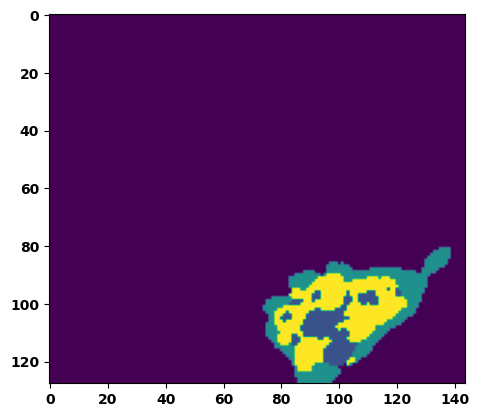

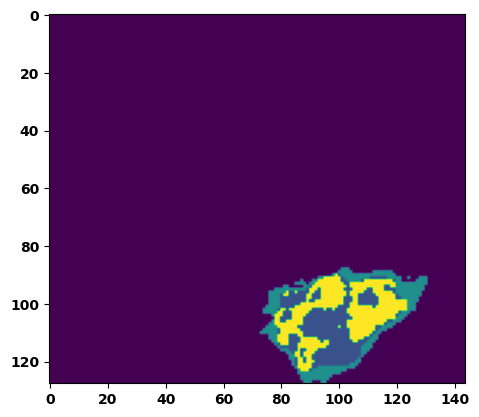

 58%|█████▊    | 21/36 [00:25<00:18,  1.24s/it]

Batch_id:  21 Test loss:  0.1358519196510315
Batch_id:  21 Test IoU:  tensor(0.7843, device='cuda:0')
Batch_id:  21 Test Mean Dice Score:  tensor(0.9882, device='cuda:0')
Batch_id:  21 Test Non-tumor Dice Score:  tensor(0.9922, device='cuda:0')
Batch_id:  21 Test NCR/NET Dice Score:  tensor(0.9936, device='cuda:0')
Batch_id:  21 Test ED Dice Score:  tensor(0.9910, device='cuda:0')
Batch_id:  21 Test ET Dice Score:  tensor(0.9878, device='cuda:0')


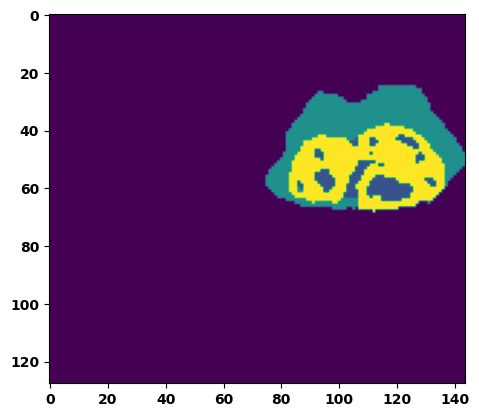

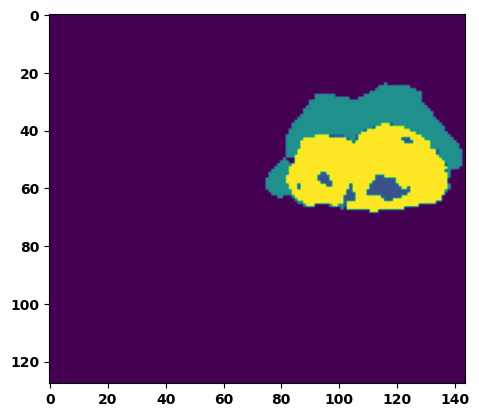

 61%|██████    | 22/36 [00:26<00:17,  1.27s/it]

Batch_id:  22 Test loss:  0.09040190279483795
Batch_id:  22 Test IoU:  tensor(0.8551, device='cuda:0')
Batch_id:  22 Test Mean Dice Score:  tensor(0.9888, device='cuda:0')
Batch_id:  22 Test Non-tumor Dice Score:  tensor(0.9899, device='cuda:0')
Batch_id:  22 Test NCR/NET Dice Score:  tensor(0.9952, device='cuda:0')
Batch_id:  22 Test ED Dice Score:  tensor(0.9889, device='cuda:0')
Batch_id:  22 Test ET Dice Score:  tensor(0.9926, device='cuda:0')


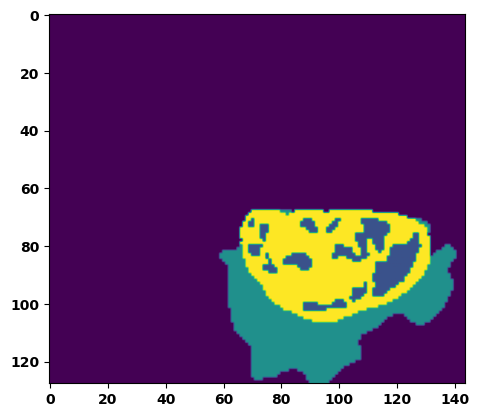

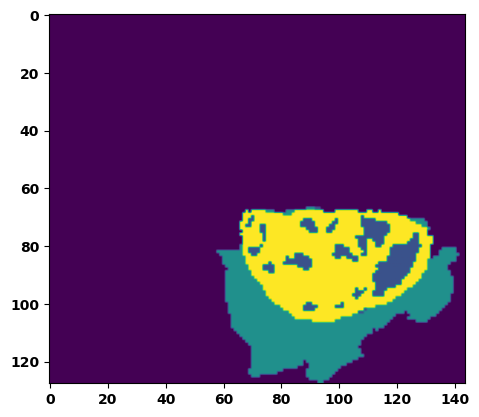

 64%|██████▍   | 23/36 [00:27<00:16,  1.26s/it]

Batch_id:  23 Test loss:  0.08697943389415741
Batch_id:  23 Test IoU:  tensor(0.8544, device='cuda:0')
Batch_id:  23 Test Mean Dice Score:  tensor(0.9921, device='cuda:0')
Batch_id:  23 Test Non-tumor Dice Score:  tensor(0.9927, device='cuda:0')
Batch_id:  23 Test NCR/NET Dice Score:  tensor(0.9973, device='cuda:0')
Batch_id:  23 Test ED Dice Score:  tensor(0.9922, device='cuda:0')
Batch_id:  23 Test ET Dice Score:  tensor(0.9941, device='cuda:0')


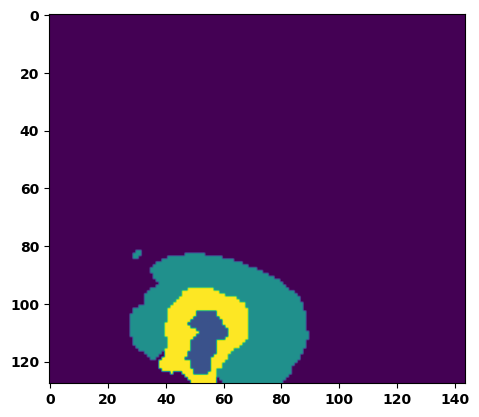

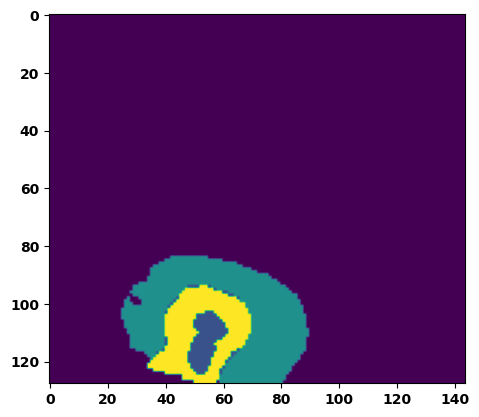

 67%|██████▋   | 24/36 [00:28<00:14,  1.22s/it]

Batch_id:  24 Test loss:  0.07838687300682068
Batch_id:  24 Test IoU:  tensor(0.8732, device='cuda:0')
Batch_id:  24 Test Mean Dice Score:  tensor(0.9936, device='cuda:0')
Batch_id:  24 Test Non-tumor Dice Score:  tensor(0.9924, device='cuda:0')
Batch_id:  24 Test NCR/NET Dice Score:  tensor(0.9991, device='cuda:0')
Batch_id:  24 Test ED Dice Score:  tensor(0.9915, device='cuda:0')
Batch_id:  24 Test ET Dice Score:  tensor(0.9979, device='cuda:0')


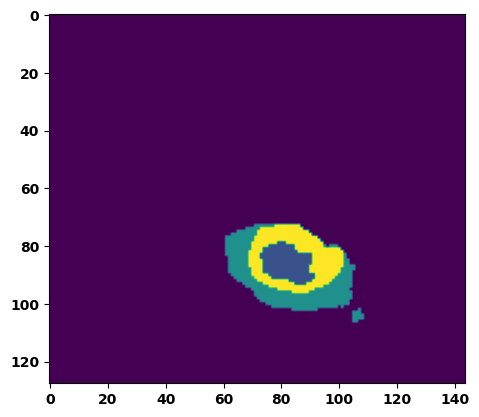

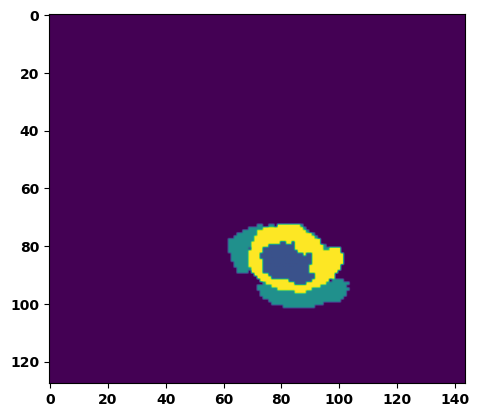

 69%|██████▉   | 25/36 [00:30<00:13,  1.21s/it]

Batch_id:  25 Test loss:  0.09694503247737885
Batch_id:  25 Test IoU:  tensor(0.8349, device='cuda:0')
Batch_id:  25 Test Mean Dice Score:  tensor(0.9660, device='cuda:0')
Batch_id:  25 Test Non-tumor Dice Score:  tensor(0.9557, device='cuda:0')
Batch_id:  25 Test NCR/NET Dice Score:  tensor(0.9972, device='cuda:0')
Batch_id:  25 Test ED Dice Score:  tensor(0.9517, device='cuda:0')
Batch_id:  25 Test ET Dice Score:  tensor(0.9933, device='cuda:0')


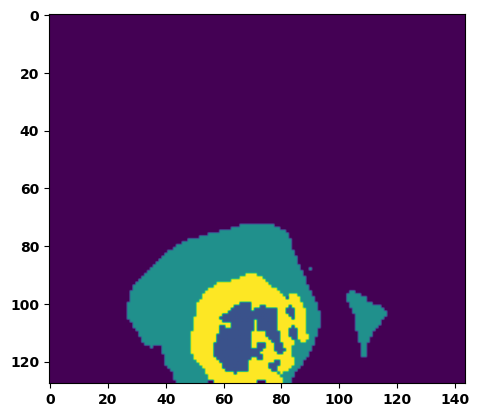

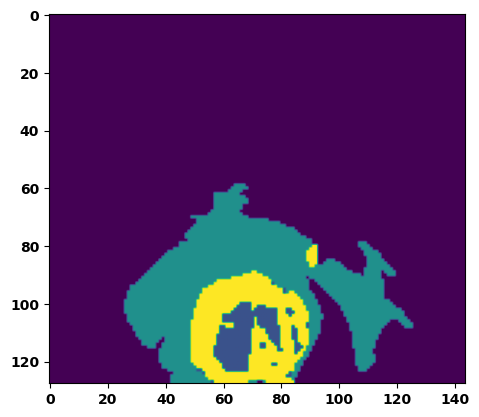

 72%|███████▏  | 26/36 [00:31<00:11,  1.20s/it]

Batch_id:  26 Test loss:  0.275465190410614
Batch_id:  26 Test IoU:  tensor(0.6109, device='cuda:0')
Batch_id:  26 Test Mean Dice Score:  tensor(0.9507, device='cuda:0')
Batch_id:  26 Test Non-tumor Dice Score:  tensor(0.9425, device='cuda:0')
Batch_id:  26 Test NCR/NET Dice Score:  tensor(0.9904, device='cuda:0')
Batch_id:  26 Test ED Dice Score:  tensor(0.9394, device='cuda:0')
Batch_id:  26 Test ET Dice Score:  tensor(0.9797, device='cuda:0')


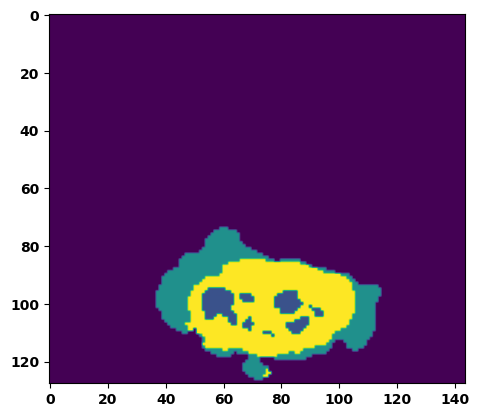

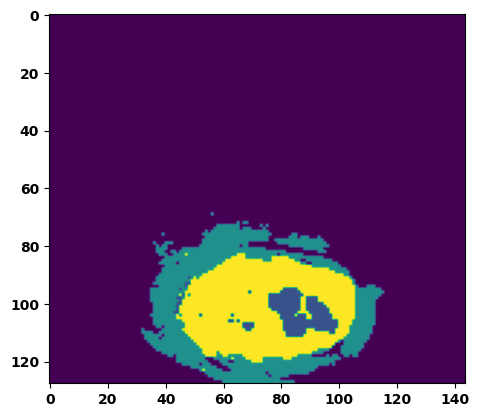

 75%|███████▌  | 27/36 [00:32<00:10,  1.17s/it]

Batch_id:  27 Test loss:  0.07326653599739075
Batch_id:  27 Test IoU:  tensor(0.8914, device='cuda:0')
Batch_id:  27 Test Mean Dice Score:  tensor(0.9950, device='cuda:0')
Batch_id:  27 Test Non-tumor Dice Score:  tensor(0.9930, device='cuda:0')
Batch_id:  27 Test NCR/NET Dice Score:  tensor(0.9997, device='cuda:0')
Batch_id:  27 Test ED Dice Score:  tensor(0.9934, device='cuda:0')
Batch_id:  27 Test ET Dice Score:  tensor(0.9987, device='cuda:0')


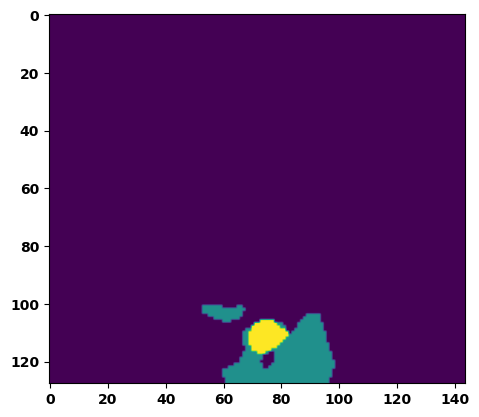

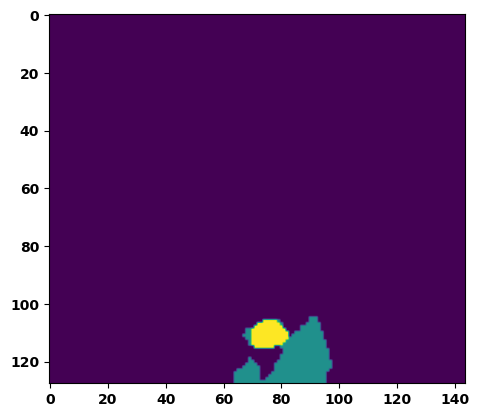

 78%|███████▊  | 28/36 [00:33<00:09,  1.15s/it]

Batch_id:  28 Test loss:  0.15514212846755981
Batch_id:  28 Test IoU:  tensor(0.7516, device='cuda:0')
Batch_id:  28 Test Mean Dice Score:  tensor(0.9732, device='cuda:0')
Batch_id:  28 Test Non-tumor Dice Score:  tensor(0.9826, device='cuda:0')
Batch_id:  28 Test NCR/NET Dice Score:  tensor(0.9808, device='cuda:0')
Batch_id:  28 Test ED Dice Score:  tensor(0.9860, device='cuda:0')
Batch_id:  28 Test ET Dice Score:  tensor(0.9702, device='cuda:0')


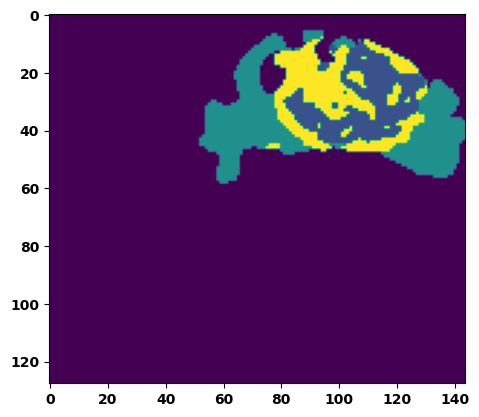

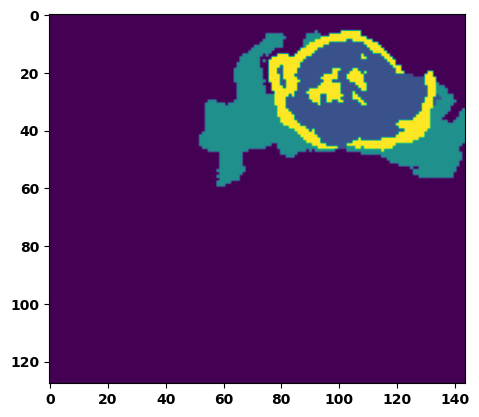

 81%|████████  | 29/36 [00:34<00:08,  1.17s/it]

Batch_id:  29 Test loss:  0.1169973760843277
Batch_id:  29 Test IoU:  tensor(0.8072, device='cuda:0')
Batch_id:  29 Test Mean Dice Score:  tensor(0.9753, device='cuda:0')
Batch_id:  29 Test Non-tumor Dice Score:  tensor(0.9651, device='cuda:0')
Batch_id:  29 Test NCR/NET Dice Score:  tensor(0.9986, device='cuda:0')
Batch_id:  29 Test ED Dice Score:  tensor(0.9647, device='cuda:0')
Batch_id:  29 Test ET Dice Score:  tensor(0.9976, device='cuda:0')


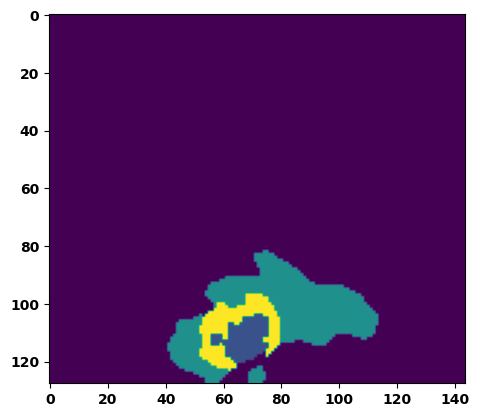

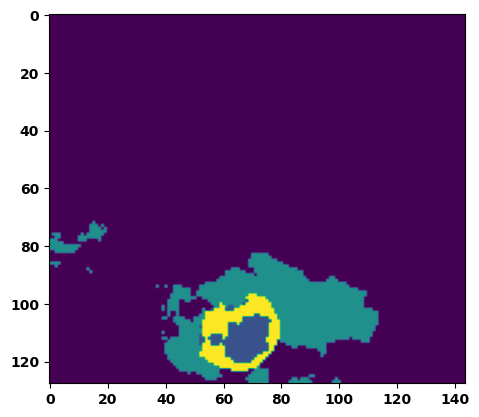

 83%|████████▎ | 30/36 [00:35<00:07,  1.17s/it]

Batch_id:  30 Test loss:  0.17672695219516754
Batch_id:  30 Test IoU:  tensor(0.7700, device='cuda:0')
Batch_id:  30 Test Mean Dice Score:  tensor(0.9927, device='cuda:0')
Batch_id:  30 Test Non-tumor Dice Score:  tensor(0.9926, device='cuda:0')
Batch_id:  30 Test NCR/NET Dice Score:  tensor(0.9972, device='cuda:0')
Batch_id:  30 Test ED Dice Score:  tensor(0.9898, device='cuda:0')
Batch_id:  30 Test ET Dice Score:  tensor(0.9986, device='cuda:0')


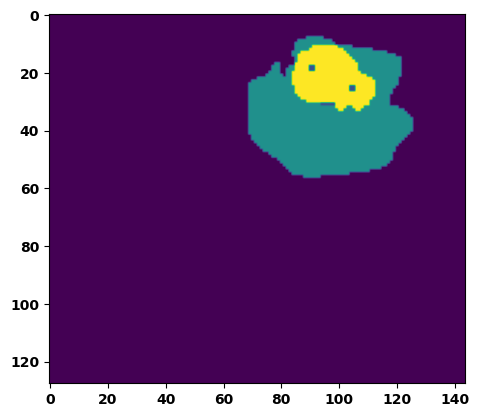

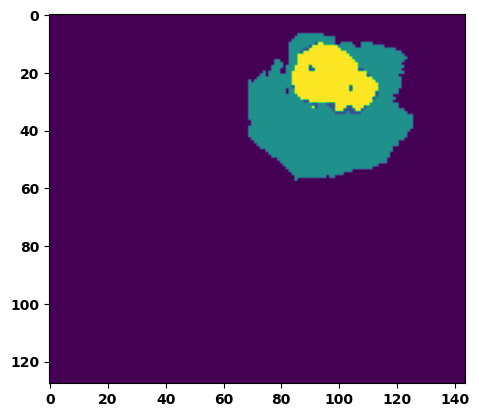

 86%|████████▌ | 31/36 [00:37<00:05,  1.16s/it]

Batch_id:  31 Test loss:  0.174842968583107
Batch_id:  31 Test IoU:  tensor(0.7266, device='cuda:0')
Batch_id:  31 Test Mean Dice Score:  tensor(0.9696, device='cuda:0')
Batch_id:  31 Test Non-tumor Dice Score:  tensor(0.9571, device='cuda:0')
Batch_id:  31 Test NCR/NET Dice Score:  tensor(0.9980, device='cuda:0')
Batch_id:  31 Test ED Dice Score:  tensor(0.9606, device='cuda:0')
Batch_id:  31 Test ET Dice Score:  tensor(0.9930, device='cuda:0')


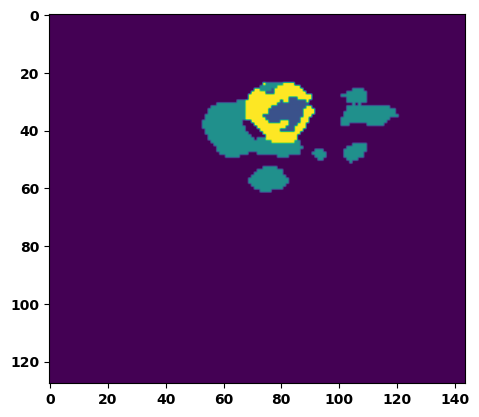

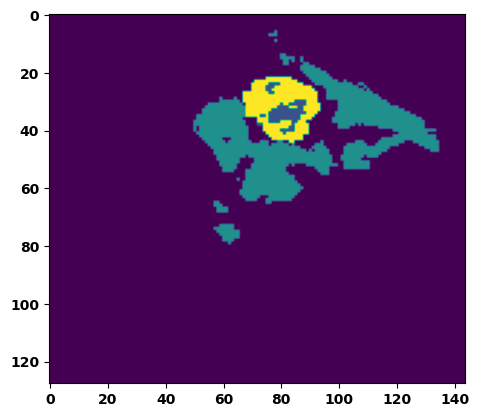

 89%|████████▉ | 32/36 [00:38<00:04,  1.16s/it]

Batch_id:  32 Test loss:  0.07714976370334625
Batch_id:  32 Test IoU:  tensor(0.8664, device='cuda:0')
Batch_id:  32 Test Mean Dice Score:  tensor(0.9876, device='cuda:0')
Batch_id:  32 Test Non-tumor Dice Score:  tensor(0.9849, device='cuda:0')
Batch_id:  32 Test NCR/NET Dice Score:  tensor(0.9975, device='cuda:0')
Batch_id:  32 Test ED Dice Score:  tensor(0.9862, device='cuda:0')
Batch_id:  32 Test ET Dice Score:  tensor(0.9940, device='cuda:0')


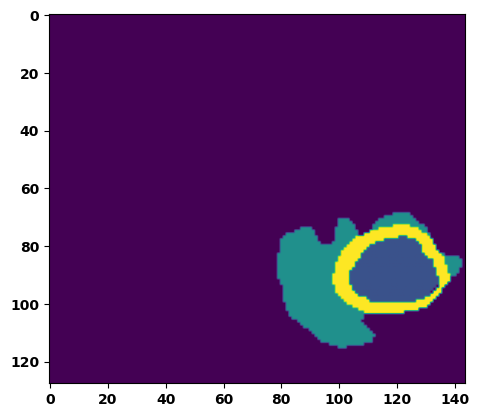

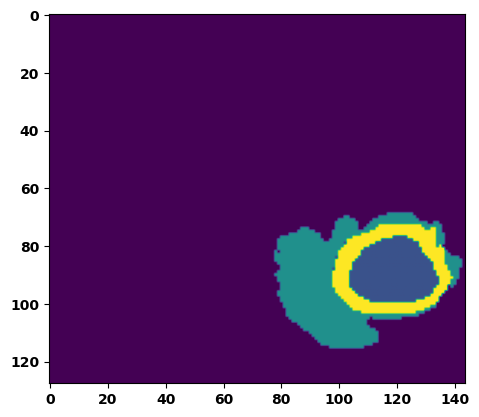

 92%|█████████▏| 33/36 [00:39<00:03,  1.19s/it]

Batch_id:  33 Test loss:  0.13483959436416626
Batch_id:  33 Test IoU:  tensor(0.7911, device='cuda:0')
Batch_id:  33 Test Mean Dice Score:  tensor(0.9575, device='cuda:0')
Batch_id:  33 Test Non-tumor Dice Score:  tensor(0.9421, device='cuda:0')
Batch_id:  33 Test NCR/NET Dice Score:  tensor(0.9973, device='cuda:0')
Batch_id:  33 Test ED Dice Score:  tensor(0.9395, device='cuda:0')
Batch_id:  33 Test ET Dice Score:  tensor(0.9937, device='cuda:0')


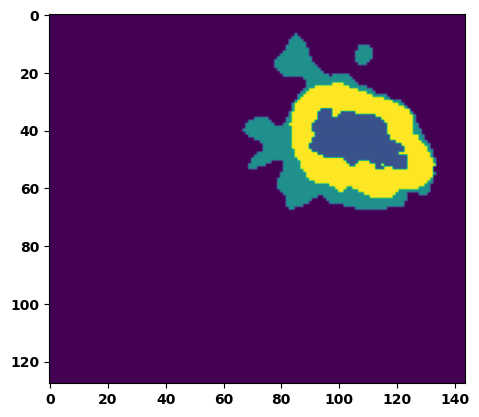

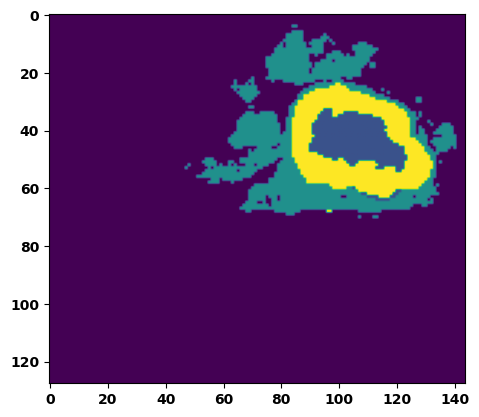

 94%|█████████▍| 34/36 [00:40<00:02,  1.17s/it]

Batch_id:  34 Test loss:  0.290586918592453
Batch_id:  34 Test IoU:  tensor(0.6175, device='cuda:0')
Batch_id:  34 Test Mean Dice Score:  tensor(0.9843, device='cuda:0')
Batch_id:  34 Test Non-tumor Dice Score:  tensor(0.9829, device='cuda:0')
Batch_id:  34 Test NCR/NET Dice Score:  tensor(0.9954, device='cuda:0')
Batch_id:  34 Test ED Dice Score:  tensor(0.9787, device='cuda:0')
Batch_id:  34 Test ET Dice Score:  tensor(0.9958, device='cuda:0')


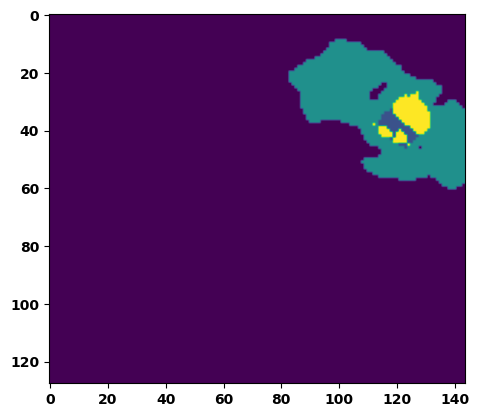

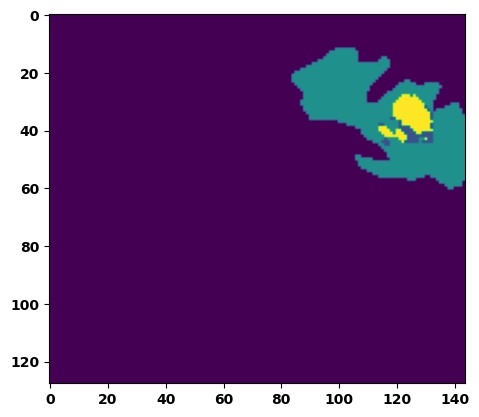

 97%|█████████▋| 35/36 [00:41<00:01,  1.19s/it]

Batch_id:  35 Test loss:  0.2249853014945984
Batch_id:  35 Test IoU:  tensor(0.6687, device='cuda:0')
Batch_id:  35 Test Mean Dice Score:  tensor(0.9883, device='cuda:0')
Batch_id:  35 Test Non-tumor Dice Score:  tensor(0.9886, device='cuda:0')
Batch_id:  35 Test NCR/NET Dice Score:  tensor(0.9947, device='cuda:0')
Batch_id:  35 Test ED Dice Score:  tensor(0.9875, device='cuda:0')
Batch_id:  35 Test ET Dice Score:  tensor(0.9941, device='cuda:0')


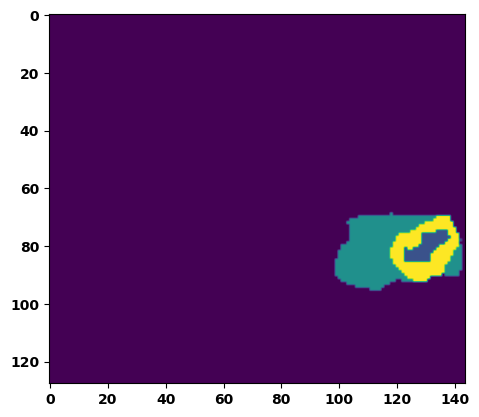

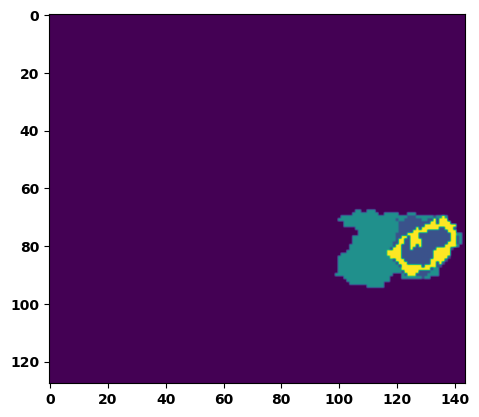

100%|██████████| 36/36 [00:42<00:00,  1.19s/it]

Avg IoU:  tensor(0.7532)
Avg Loss:  0.171345551394754
Avg Dice Scores:  tensor(0.9784)
Non-Tumor Dice Scores:  tensor(0.9770)
NCR/NET Dice Scores:  tensor(0.9918)
ED Dice Scores:  tensor(0.9740)
ET Dice Scores:  tensor(0.9923)


In [40]:
"""
yellow - label 4
dark blue - label 1 
green - label 2 

purple - label 0
"""

main(0.75)